Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import shutil

CIFAR10



In [2]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Filter images containing dogs (class 5 in CIFAR-10)
dog_indices_train = np.where(train_labels == 5)[0]
dog_indices_test = np.where(test_labels == 5)[0]

# Create new labels: 1 for dogs, 0 for everything else
train_labels_binary = np.zeros((len(train_labels), 1))
train_labels_binary[dog_indices_train] = 1

test_labels_binary = np.zeros((len(test_labels), 1))
test_labels_binary[dog_indices_test] = 1

# Filter images containing dogs and non-dog images
train_images_dog = train_images[dog_indices_train]
train_images_nondog = np.delete(train_images, dog_indices_train, axis=0)

test_images_dog = test_images[dog_indices_test]
test_images_nondog = np.delete(test_images, dog_indices_test, axis=0)

# Combine dog and non-dog images
train_images_final = np.concatenate((train_images_dog, train_images_nondog))
test_images_final = np.concatenate((test_images_dog, test_images_nondog))

# Combine dog and non-dog labels
train_labels_final = np.concatenate((train_labels_binary[dog_indices_train], np.zeros((len(train_images_nondog), 1))))
test_labels_final = np.concatenate((test_labels_binary[dog_indices_test], np.zeros((len(test_images_nondog), 1))))

# Determine the number of non-dog images to delete
num_images_to_delete = 35000

# Delete the specified number of non-dog images
train_images_nondog_balanced = np.delete(train_images_nondog, range(num_images_to_delete), axis=0)

# Update the combined train images and labels
train_images_final = np.concatenate((train_images_dog, train_images_nondog_balanced))
train_labels_final = np.concatenate((train_labels_binary[dog_indices_train], np.zeros((len(train_images_nondog_balanced), 1))))

# Create an ImageDataGenerator instance for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the ImageDataGenerator to your training data
datagen.fit(train_images_final)

Models


In [3]:
# Define the model architecture

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.5),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 30, 30, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                        

Training

Epoch 1/30
469/469 [==============================] - 21s 32ms/step - loss: 0.8796 - accuracy: 0.7189 - val_loss: 0.5283 - val_accuracy: 0.8958
Epoch 2/30
469/469 [==============================] - 10s 21ms/step - loss: 0.6356 - accuracy: 0.7831 - val_loss: 0.4353 - val_accuracy: 0.8766
Epoch 3/30
469/469 [==============================] - 10s 21ms/step - loss: 0.5421 - accuracy: 0.7995 - val_loss: 0.3174 - val_accuracy: 0.9009
Epoch 4/30
469/469 [==============================] - 11s 23ms/step - loss: 0.4742 - accuracy: 0.8149 - val_loss: 0.2714 - val_accuracy: 0.9047
Epoch 5/30
469/469 [==============================] - 12s 25ms/step - loss: 0.4254 - accuracy: 0.8225 - val_loss: 0.3292 - val_accuracy: 0.8821
Epoch 6/30
469/469 [==============================] - 11s 24ms/step - loss: 0.4042 - accuracy: 0.8303 - val_loss: 0.3430 - val_accuracy: 0.9083
Epoch 7/30
469/469 [==============================] - 12s 25ms/step - loss: 0.3804 - accuracy: 0.8377 - val_loss: 0.2322 - val_accuracy:

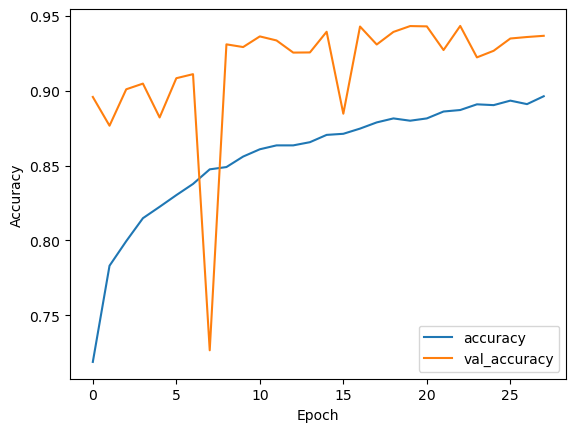

In [4]:
# Training

# Split dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images_final, train_labels_final, test_size=0.2, random_state=42)

# Compile model with binary cross-entropy loss and appropriate optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model on training set, validating on validation set
#history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])
# Train your model with augmented data
history = model.fit(datagen.flow(train_images_final, train_labels_final, batch_size=32), epochs=30, validation_data=(test_images_final, test_labels_final),callbacks=[early_stopping])

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


Evaluation

In [5]:
# Evaluation

# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(test_images_final, test_labels_final)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Optionally, you can calculate additional evaluation metrics using scikit-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predictions on test set
y_pred = model.predict(test_images_final)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Calculate evaluation metrics
accuracy = accuracy_score(test_labels_final, y_pred_binary)
precision = precision_score(test_labels_final, y_pred_binary)
recall = recall_score(test_labels_final, y_pred_binary)
f1 = f1_score(test_labels_final, y_pred_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


313/313 [==============================] - 2s 6ms/step - loss: 0.1525 - accuracy: 0.9432
Test Loss: 0.15248176455497742
Test Accuracy: 0.9431999921798706
313/313 [==============================] - 1s 4ms/step
Accuracy: 0.9432
Precision: 0.711764705882353
Recall: 0.726
F1-score: 0.7188118811881188


Confusion matrix

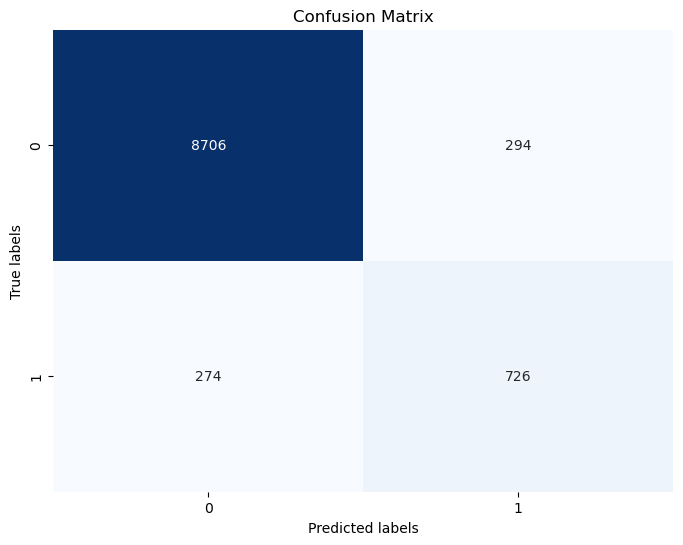

In [6]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_labels_final, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


Save Model

In [7]:
# Optionally, you can save the trained model for later use
model.save("better_dog_detection_model.h5")

Covert Model to  TF Lite

In [8]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file with the desired filename
tflite_filename = "g_dog_detect_model_data.tflite"
with open(tflite_filename, "wb") as f:
    f.write(tflite_model)

# Specify the destination directory where you want to copy the TensorFlow Lite model
destination_directory = r"C:\Users\diego\OneDrive\Desktop\ML IoT\Project 1 Arduino\dog_detection"

# Copy the TensorFlow Lite model to the destination directory
shutil.copy(tflite_filename, destination_directory)


INFO:tensorflow:Assets written to: C:\Users\diego\AppData\Local\Temp\tmpr4fm_0zr\assets


INFO:tensorflow:Assets written to: C:\Users\diego\AppData\Local\Temp\tmpr4fm_0zr\assets


'C:\\Users\\diego\\OneDrive\\Desktop\\ML IoT\\Project 1 Arduino\\dog_detection\\g_dog_detect_model_data.tflite'

Tests

1/1 [==============================] - 1s 591ms/step


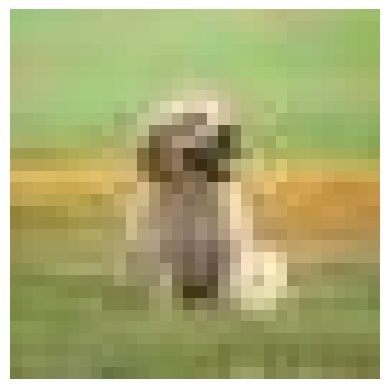

It's a dog.


In [9]:
# Function to preprocess the uploaded image
def preprocess_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(32, 32))  # Assuming your model expects input images of size 32x32
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Path to the uploaded image
uploaded_image_path = 'dog.jpg'

# Preprocess the uploaded image
preprocessed_image = preprocess_image(uploaded_image_path)

# Make predictions using your trained model
predictions = model.predict(preprocessed_image)

# Display the image
plt.imshow(preprocessed_image[0]/255.0)  # Assuming the pixel values are normalized in the range [0, 1]
plt.axis('off')
plt.show()

# Interpret the predictions
if predictions[0][0] > 0.5:
    print("It's a dog.")
else:
    print("It's not a dog.")


1/1 [==============================] - 0s 23ms/step


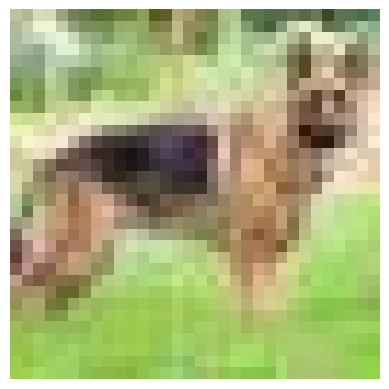

It's not a dog.


In [10]:
# Function to preprocess the uploaded image
def preprocess_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(32, 32))  # Assuming your model expects input images of size 32x32
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Path to the uploaded image
uploaded_image_path = 'dog1.jpg'

# Preprocess the uploaded image
preprocessed_image = preprocess_image(uploaded_image_path)

# Make predictions using your trained model
predictions = model.predict(preprocessed_image)

# Display the image
plt.imshow(preprocessed_image[0]/255.0)  # Assuming the pixel values are normalized in the range [0, 1]
plt.axis('off')
plt.show()

# Interpret the predictions
if predictions[0][0] > 0.5:
    print("It's a dog.")
else:
    print("It's not a dog.")


1/1 [==============================] - 0s 25ms/step


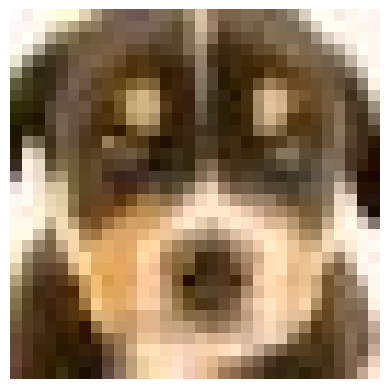

It's a dog.


In [11]:
# Function to preprocess the uploaded image
def preprocess_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(32, 32))  # Assuming your model expects input images of size 32x32
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Path to the uploaded image
uploaded_image_path = 'dog2.jpg'

# Preprocess the uploaded image
preprocessed_image = preprocess_image(uploaded_image_path)

# Make predictions using your trained model
predictions = model.predict(preprocessed_image)

# Display the image
plt.imshow(preprocessed_image[0]/255.0)  # Assuming the pixel values are normalized in the range [0, 1]
plt.axis('off')
plt.show()

# Interpret the predictions
if predictions[0][0] > 0.5:
    print("It's a dog.")
else:
    print("It's not a dog.")


1/1 [==============================] - 0s 28ms/step


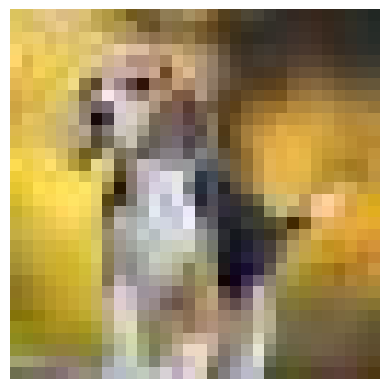

It's a dog.


In [12]:


# Function to preprocess the uploaded image
def preprocess_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(32, 32))  # Assuming your model expects input images of size 32x32
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Path to the uploaded image
uploaded_image_path = 'dog3.jpg'

# Preprocess the uploaded image
preprocessed_image = preprocess_image(uploaded_image_path)

# Make predictions using your trained model
predictions = model.predict(preprocessed_image)

# Display the image
plt.imshow(preprocessed_image[0]/255.0)  # Assuming the pixel values are normalized in the range [0, 1]
plt.axis('off')
plt.show()

# Interpret the predictions
if predictions[0][0] > 0.5:
    print("It's a dog.")
else:
    print("It's not a dog.")
